<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/Day2-AfterLunch/notebooks/student_simple_gaussian_model_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/PGM-Lab/2022-ProbAI/raw/main/Day2-AfterLunch/notebooks/Figures/simple_pyro_exercise.png" width="800">


In [1]:
import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

## Generate some data

In [2]:
# Sample data
np.random.seed(123)
N = 100
correct_mean = 5
correct_precision = 1
data = torch.tensor(np.random.normal(loc=correct_mean, scale=np.sqrt(1./correct_precision), size=N), dtype=torch.float)

## Our model specification

In [3]:
def model(data):
    gamma = pyro.sample("gamma", Gamma(torch.tensor(1.), torch.tensor(1.)))
    mu = pyro.sample("mu", Normal(torch.zeros(1), torch.tensor(10000.0)))
    with pyro.plate("data", len(data)):
        pyro.sample("x", Normal(loc=mu, scale=torch.sqrt(1. / gamma)), obs=data)

## Our guide specification

In [5]:
# Define the right guide for the above model, including the variational parameters. 
def guide(data=None):
    # Variational parameters for gamma
    gamma_a = pyro.param("gamma_a", torch.tensor(1.), constraint=constraints.positive)
    gamma_b = pyro.param("gamma_b", torch.tensor(1.), constraint=constraints.positive)
    
    # Variational parameters for mu
    mu_loc = pyro.param("mu_loc", torch.tensor(0.))
    mu_scale = pyro.param("mu_scale", torch.tensor(1.), constraint=constraints.positive)
    
    # Register the variational parameters with Pyro
    gamma = pyro.sample("gamma", Gamma(gamma_a, gamma_b))
    mu = pyro.sample("mu", Normal(mu_loc, mu_scale))

## Do learning

In [6]:
# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)

pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(3000):
    loss = svi.step(data)
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

[epoch 000] average training loss: 641.7271
[epoch 500] average training loss: 305.4049
[epoch 1000] average training loss: 359.5485
[epoch 1500] average training loss: 185.8212
[epoch 2000] average training loss: 182.1426
[epoch 2500] average training loss: 168.0064


In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

gamma_a tensor(3.8956, grad_fn=<AddBackward0>)
gamma_b tensor(4.5496, grad_fn=<AddBackward0>)
mu_loc tensor(5.0188, requires_grad=True)
mu_scale tensor(0.1759, grad_fn=<AddBackward0>)


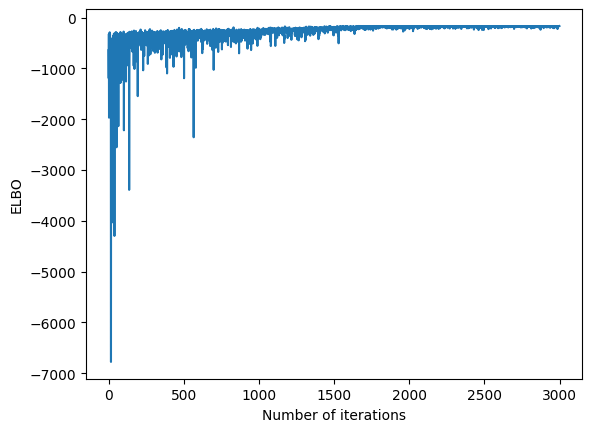

In [8]:
plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()